In [ ]:
import operator
import random
from typing import Annotated, TypedDict

from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph

**Data Processing**

In [ ]:
class State(TypedDict):
    """State holds the workflow state for the graph.

    input: int
        Initial input value.
    partial: Annotated[List[int], operator.add]
        List of partial results, combined with operator.add.
    results: Annotated[List[int], operator.add]
        List of final results, combined with operator.add.
    """

    input: int
    partial: Annotated[list[int], operator.add]
    results: Annotated[list[int], operator.add]

In [ ]:
def node_a(state: State, config: RunnableConfig) -> dict[str, list[int]]:
    """Process the input state and config to generate partial and result values.

    Args:
        state (State): The workflow state containing input values.
        config (RunnableConfig): Configuration for the node, may include 'offset'.

    Returns:
        dict: Dictionary with 'partial' and 'results' lists.

    """
    offset = 0
    if config:
        offset = config.get("configurable", {}).get("offset", 0)
    partial = random.randint(1, 10) + offset  # noqa: S311
    output = state["input"] + partial
    print(
        f"NODE A:\n "
        f"->input:{output - partial}\n "
        f"->offset:{offset}\n "
        f"->random:{partial - offset}\n "
        f"->partial:{partial}\n "
        f"->output:{output}\n "
    )
    return {"partial": [partial], "results": [output]}  # pyright: ignore[reportUnknownVariableType]

In [ ]:
def node_b(state: State, config: RunnableConfig) -> dict[str, list[int]]:
    """Process the input state and config to generate partial and result values.

    Args:
        state (State): The workflow state containing input values.
        config (RunnableConfig): Configuration for the node, may include 'offset'.

    Returns:
        dict: Dictionary with 'partial' and 'results' lists.

    """
    offset = 0
    if config:
        offset = config.get("configurable", {}).get("offset", 0)
    partial = random.randint(1, 10) + offset  # noqa: S311
    output = state["results"][-1] + partial
    print(
        f"NODE B:\n "
        f"->input:{output - partial}\n "
        f"->offset:{offset}\n "
        f"->random:{partial - offset}\n "
        f"->partial:{partial}\n "
        f"->output:{output}\n "
    )
    return {"partial": [partial], "results": [output]}

In [ ]:
workflow = StateGraph(State)

In [ ]:
workflow.add_node(node_a)
workflow.add_node(node_b)

In [ ]:
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

In [ ]:
graph = workflow.compile()

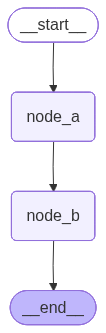

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"offset": 20}}
graph.invoke(
    input={
        "input": 1,
    },
    config=config,
)

NODE A:
 ->input:1
 ->offset:20
 ->random:8
 ->partial:28
 ->output:29
 
NODE B:
 ->input:29
 ->offset:20
 ->random:10
 ->partial:30
 ->output:59
 


{'input': 1, 'partial': [28, 30], 'results': [29, 59]}

**Call LLMs**

In [ ]:
from dotenv import load_dotenv

load_dotenv()
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [ ]:
class State(MessagesState):
    """State holds the workflow state for the graph.

    question: str
        The question to be processed.
    """

    question: str

In [ ]:
def model(
    state: State, config: RunnableConfig
) -> dict[str, list[HumanMessage | SystemMessage]]:
    """Process the input state and configuration to interact with the LLM.

    Args:
        state (State): The workflow state containing the question and messages.
        config (RunnableConfig): Configuration for the node, may include 'name'.

    Returns:
        dict: Dictionary with updated 'messages' list.

    """
    question = state["question"]
    messages = state["messages"]
    name = None
    if config:
        name = config["configurable"].get("name")

    if name and not messages:
        messages.append(
            SystemMessage(
                "Help the following user. \n"
                f"Name={name} \n"
                "Give an initial greeting before responding."
            )
        )

    messages.append(HumanMessage(question))
    response = llm.invoke(messages)
    messages.append(response)

    return {"messages": messages}

In [ ]:
workflow = StateGraph(State)

In [ ]:
workflow.add_node("model", model)

In [ ]:
workflow.add_edge(START, "model")
workflow.add_edge("model", END)

In [ ]:
graph = workflow.compile()

In [ ]:
result = graph.invoke(
    input={"question": "What's the name of Ash's first pokémon?"},
    config={"configurable": {"name": "James"}},
)

In [ ]:
for message in result["messages"]:
    message.pretty_print()

================================ System Message ================================

Help the following user. 
Name=James 
Give an initial greeting before responding.
================================ Human Message =================================

What's the name of Ash's first pokémon?
================================== Ai Message ==================================

Hello, James! Ash's first Pokémon is Pikachu. It became his iconic partner right from the start of his journey in the Pokémon anime. If you have any more questions about Pokémon or anything else, feel free to ask!
